In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import numpy as np
from pprint import pprint
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import grad
import torchvision
from torchvision import models, datasets, transforms

# Utils

In [2]:
def label_to_onehot(target, num_classes=100):
    target = torch.unsqueeze(target, 1)
    onehot_target = torch.zeros(target.size(0), num_classes, device=target.device)
    onehot_target.scatter_(1, target, 1)
    return onehot_target

def cross_entropy_for_onehot(pred, target):
    return torch.mean(torch.sum(- target * F.log_softmax(pred, dim=-1), 1))

# Models

In [3]:
def weight_init(m):
    if hasattr(m, "weight"):
        m.weight.data.uniform_(-0.5,0.5)
    if hasattr(m, "bias"):
        m.bias.data.uniform_(-0.5,0.5)

## LeNet

In [4]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        
        self.body = nn.Sequential(
            nn.Conv2d(3, 12, kernel_size=5, padding=5//2, stride=2),
            nn.Sigmoid(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=2),
            nn.Sigmoid(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=1),
            nn.Sigmoid(),
        )
        self.fc = nn.Sequential(
            nn.Linear(768,100)
        )
    
    def forward(self,x):
        out = self.body(x)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        
        return out

# iDLG

In [5]:
device = "cuda"

In [6]:
dst = datasets.CIFAR100("~/.torch", download=True)
tp = transforms.ToTensor()
tt = transforms.ToPILImage()

Files already downloaded and verified


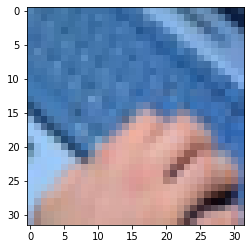

In [7]:
#Example image print
img_index = 10
gt_data = tp(dst[img_index][0]).to(device)

gt_data = gt_data.view(1, *gt_data.size())
gt_label = torch.Tensor([dst[img_index][1]]).long().to(device)
gt_label = gt_label.view(1,)
gt_onehot_label = label_to_onehot(gt_label)

plt.imshow(tt(gt_data[0].cpu()))

In [8]:
#LeNet
net = LeNet().to(device)

torch.manual_seed(42)
#weight init
net.apply(weight_init)

criterion = nn.CrossEntropyLoss().to(device)

#Number of iterations (Write only a multiple of 100)
iteration = 300

In [9]:
#Predicted value of example image
pred = net(gt_data)
print(pred)
y = criterion(pred, gt_onehot_label)
print(y)
#Take original dy_dx
dy_dx = torch.autograd.grad(y, net.parameters())
original_dy_dx = list((_.detach().clone() for _ in dy_dx))

tensor([[  6.8709,  -2.9454,   8.0138,  -5.7521,  -0.8706,  -4.0166,   1.1319,
          -4.1388,   3.6100,   7.7670,   7.2746,  -4.5045,   3.3784,   8.9390,
          -5.6579,  -6.0230,   3.2055,  -9.6423,  -3.5373,   0.1439,   7.0566,
          -0.9021,  -4.5339,  -2.6825,  -3.8286,   2.4950,  -3.1593,  -4.7076,
           4.9020,   0.3076,  -0.4380,  -1.0041,  -3.2665,   0.9332,  -2.6222,
          -8.5135,  -0.2219,   1.2211,  -4.2308,   3.0052,   2.6029,   1.0473,
           7.1143,   0.1081,  -0.2133,   4.9683,  -3.0466,  -9.2495,  -4.7558,
          -6.2200,  -2.0391,   3.8870,  -0.9381,   3.2977,  -3.8643,  -0.6721,
          -1.9916,  -0.1806,   2.4187,   7.7006,  -2.7709,   4.3151,  -5.2857,
          -0.1580,   4.7699,  -2.6992,  -6.8163,  -1.1528,   1.5306,  -3.9444,
          -1.4108,  -1.7218,   1.4665,   3.8873,  -5.6664,  -3.3854,   5.1642,
          -7.3596,  10.3404,  -2.9975, -10.6514,  -7.1582,   1.9226,  -3.9350,
          -9.0238,  -6.7153,  -2.4747,  -3.4158,  -5

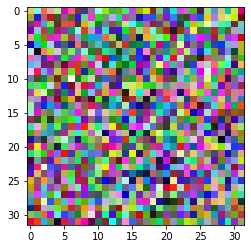

In [10]:
#Create Dummy image
dummy_data = torch.randn(gt_data.size()).to(device).requires_grad_(True)
plt.imshow(tt(dummy_data[0].cpu()))

In [11]:
#without dummy_label
optimizer = torch.optim.LBFGS([dummy_data, ])
#Get Ground-truth label
label_pred = torch.argmin(torch.sum(original_dy_dx[-2], dim=-1), dim=-1).detach().reshape((1,)).requires_grad_(False)

criterion = nn.CrossEntropyLoss().to(device)

history = []
for iters in range(iteration):
    def closure():
        optimizer.zero_grad()
        
        dummy_pred = net(dummy_data)
        dummy_loss = criterion(dummy_pred, label_pred)
        dummy_dy_dx = torch.autograd.grad(dummy_loss, net.parameters(), create_graph=True)
        
        grad_diff = 0
        for gx, gy in zip(dummy_dy_dx, original_dy_dx):
            grad_diff += ((gx - gy) ** 2).sum()
        grad_diff.backward()
        
        return grad_diff
    
    optimizer.step(closure)
    
    if iters%10==0:
        current_loss = closure()
        print(iters, "%.4f" % current_loss.item())
        history.append(tt(dummy_data[0].cpu()))

0 49.4371
10 1.1180
20 0.1608
30 0.0568
40 0.0250
50 0.0154
60 0.0110
70 0.0086
80 0.0071
90 0.0059
100 0.0050
110 0.0043
120 0.0037
130 0.0034
140 0.0031
150 0.0028
160 0.0025
170 0.0024
180 0.0022
190 0.0021
200 0.0019
210 0.0018
220 0.0017
230 0.0016
240 0.0015
250 0.0015
260 0.0014
270 0.0014
280 0.0013
290 0.0012


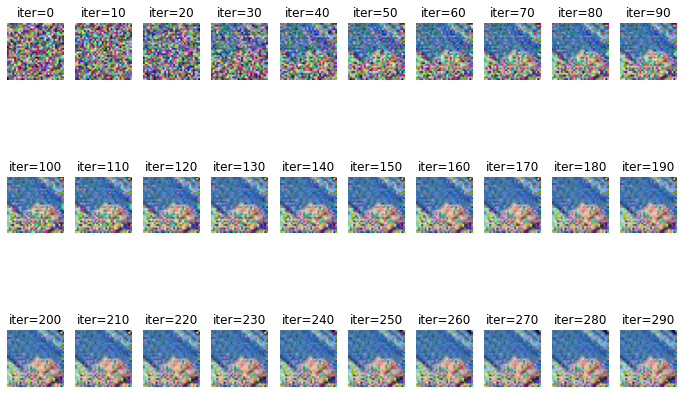

In [12]:
plt.figure(figsize=(12,8))
for i in range(int(iteration/10)):
    plt.subplot(int(iteration/100),10,i+1)
    plt.imshow(history[i])
    plt.title("iter=%d"%(i*10))
    plt.axis('off')
    
plt.show()